In [5]:
!pip install segmentation_models_pytorch 
import time, segmentation_models_pytorch as smp
from tqdm import tqdm
from torch.nn import functional as F
import json, os, torch, cv2, numpy as np, albumentations as A
from PIL import Image; from matplotlib import pyplot as plt
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import random
from torchvision import transforms as tfs

In [6]:
class CustomSegmentationDataset(Dataset):
    
    def __init__(self, root, transformations = None):

        self.im_paths = sorted(glob(f"{root}/images/*.png"))
        self.gt_paths = sorted(glob(f"{root}/masks/*.png"))
        self.transformations = transformations
        self.n_cls = 2
        
        assert len(self.im_paths) == len(self.gt_paths)
        
    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):
        
        im, gt = self.get_im_gt(self.im_paths[idx], self.gt_paths[idx])
        
        if self.transformations: im, gt = self.apply_transformations(im, gt)
        
        return im, gt
        
    def get_im_gt(self, im_path, gt_path): return self.read_im(im_path), self.read_im(gt_path)

    def read_im(self, path): return cv2.cvtColor(cv2.imread(path, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)

    def apply_transformations(self, im, gt): transformed = self.transformations(image = im, mask = gt); return transformed["image"], transformed["mask"]

def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 8):
        
    assert sum(split) == 1., "Sum of the split must be exactly 1"
    
    ds = CustomSegmentationDataset(root = root, transformations = transformations)
    n_cls = ds.n_cls
    
    tr_len = int(len(ds) * split[0])
    val_len = int(len(ds) * split[1])
    test_len = len(ds) - (tr_len + val_len)
    
    # Data split
    tr_ds, val_ds, test_ds = torch.utils.data.random_split(ds, [tr_len, val_len, test_len])
    # Get dataloaders
    tr_dl  = DataLoader(dataset = tr_ds, batch_size = bs, shuffle = True, num_workers = ns, drop_last = True)
    val_dl = DataLoader(dataset = val_ds, batch_size = bs, shuffle = False, num_workers = ns, drop_last = True)
    test_dl = DataLoader(dataset = test_ds, batch_size = 1, shuffle = False, num_workers = ns, drop_last = True)
    
    return tr_dl, val_dl, test_dl, n_cls

root = "/kaggle/input/plant-semantic-segmentation/Plant segmentation"
mean, std, im_h, im_w = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224, 224
trans = A.Compose( [A.Resize(im_h, im_w), A.augmentations.transforms.Normalize(mean = mean, std = std), ToTensorV2(transpose_mask = True) ])
tr_dl, val_dl, test_dl, n_cls = get_dls(root = root, transformations = trans, bs = 2)

In [7]:


model = smp.DeepLabV3Plus(classes = n_cls)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 3e-4)

class Metrics():
    
    def __init__(self, pred, gt, loss_fn, eps = 1e-10, n_cls = 2):
        
        self.pred, self.gt = torch.argmax(F.softmax(pred, dim=1), dim = 1), gt # (batch, width, height)
        self.loss_fn, self.eps, self.n_cls, self.pred_ = loss_fn, eps, n_cls, pred
        
    def to_contiguous(self, inp): return inp.contiguous().view(-1) 
    
    def PA(self):

        with torch.no_grad():
            match = torch.eq(self.pred, self.gt).int()
        
        return float(match.sum()) / float(match.numel())

    def mIoU(self):
        
        with torch.no_grad():
            self.gt = torch.argmax(self.gt, dim = 1)
            
            pred, gt = self.to_contiguous(self.pred), self.to_contiguous(self.gt)

            iou_per_class = []
            
            for c in range(self.n_cls):
                
                match_pred = pred == c
                match_gt   = gt == c

                if match_gt.long().sum().item() == 0: iou_per_class.append(np.nan)
                    
                else:
                    
                    intersect = torch.logical_and(match_pred, match_gt).sum().float().item()
                    union = torch.logical_or(match_pred, match_gt).sum().float().item()

                    iou = (intersect + self.eps) / (union + self.eps)
                    iou_per_class.append(iou)
                    
            return np.nanmean(iou_per_class)
    
    def loss(self): return self.loss_fn(self.pred_, torch.argmax(self.gt, dim = 1))

In [8]:
def train(model, tr_dl, val_dl, loss_fn, opt, device, epochs, save_prefix, threshold = 0.005, save_path = "saved_models"):
    tr_loss, tr_pa, tr_iou = [], [], []
    val_loss, val_pa, val_iou = [], [], []
    tr_len, val_len = len(tr_dl), len(val_dl)
    best_loss, decrease, not_improve, early_stop_threshold = np.inf, 1, 0, 5
    os.makedirs(save_path, exist_ok=True)
    model.to(device)
    for epoch in range(1, epochs + 1):
        tr_loss_, tr_iou_, tr_pa_ = 0, 0, 0
        model.train()
        for idx, batch in enumerate(tqdm(tr_dl)):
            
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)

            preds = model(ims)

            met = Metrics(preds, gts, loss_fn, n_cls = n_cls)
            loss_ = met.loss()

            tr_iou_ += met.mIoU()

            tr_pa_ += met.PA()
            tr_loss_ += loss_.item()

            loss_.backward()
            opt.step()
            opt.zero_grad()
        model.eval()
        val_loss_, val_iou_, val_pa_ = 0, 0, 0
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(val_dl)):

                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)

                preds = model(ims)

                met = Metrics(preds, gts, loss_fn, n_cls = n_cls)

                val_loss_ += met.loss().item()
                val_iou_ += met.mIoU()
                val_pa_ += met.PA()

        tr_loss_ /= tr_len
        tr_iou_ /= tr_len
        tr_pa_ /= tr_len

        val_loss_ /= val_len
        val_iou_ /=  val_len
        val_pa_ /=   val_len
        print(f"Epoch {epoch}->Train Loss:{tr_loss_:.3f},Train PA:{tr_pa_:.3f},Validation Loss:{val_loss_:.3f},Validation PA:{val_pa_:.3f}")
        print(f"Train IoU:{tr_iou_:.3f},Validation IoU:{val_iou_:.3f}")
        tr_loss.append(tr_loss_)
        tr_iou.append(tr_iou_)
        tr_pa.append(tr_pa_)

        val_loss.append(val_loss_)
        val_iou.append(val_iou_)
        val_pa.append(val_pa_)
        
        if best_loss > (val_loss_ + threshold):
            best_loss = val_loss_
            decrease += 1
            if decrease % 2 == 0:
                torch.save(model, f"{save_path}/{save_prefix}_best_model.pt")

        else:

            not_improve += 1
            best_loss = val_loss_
            if not_improve == early_stop_threshold:
                break
    
    
    return {"tr_loss": tr_loss, "tr_iou": tr_iou, "tr_pa": tr_pa,
            "val_loss": val_loss, "val_iou": val_iou, "val_pa" : val_pa}

device = "cuda" if torch.cuda.is_available() else "cpu"

history = train(model = model, tr_dl = tr_dl, val_dl = val_dl,
                 loss_fn = loss_fn, opt = optimizer, device = device,
                 epochs = 30, save_prefix = "plant")

100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Epoch 1->Train Loss:0.257,Train PA:0.934,Validation Loss:0.107,Validation PA:0.969
Train IoU:0.543,Validation IoU:0.740


100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch 2->Train Loss:0.077,Train PA:0.977,Validation Loss:0.082,Validation PA:0.970
Train IoU:0.677,Validation IoU:0.760


100%|██████████| 3/3 [00:01<00:00,  1.83it/s]


Epoch 3->Train Loss:0.062,Train PA:0.978,Validation Loss:0.073,Validation PA:0.971
Train IoU:0.687,Validation IoU:0.766


100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


Epoch 4->Train Loss:0.056,Train PA:0.979,Validation Loss:0.070,Validation PA:0.972
Train IoU:0.691,Validation IoU:0.770


100%|██████████| 3/3 [00:01<00:00,  1.85it/s]


Epoch 5->Train Loss:0.054,Train PA:0.979,Validation Loss:0.067,Validation PA:0.973
Train IoU:0.703,Validation IoU:0.764


100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


Epoch 6->Train Loss:0.052,Train PA:0.979,Validation Loss:0.064,Validation PA:0.973
Train IoU:0.697,Validation IoU:0.777


100%|██████████| 3/3 [00:01<00:00,  1.86it/s]


Epoch 7->Train Loss:0.050,Train PA:0.980,Validation Loss:0.063,Validation PA:0.973
Train IoU:0.697,Validation IoU:0.780


100%|██████████| 3/3 [00:01<00:00,  1.82it/s]

Epoch 8->Train Loss:0.048,Train PA:0.980,Validation Loss:0.064,Validation PA:0.973
Train IoU:0.707,Validation IoU:0.764


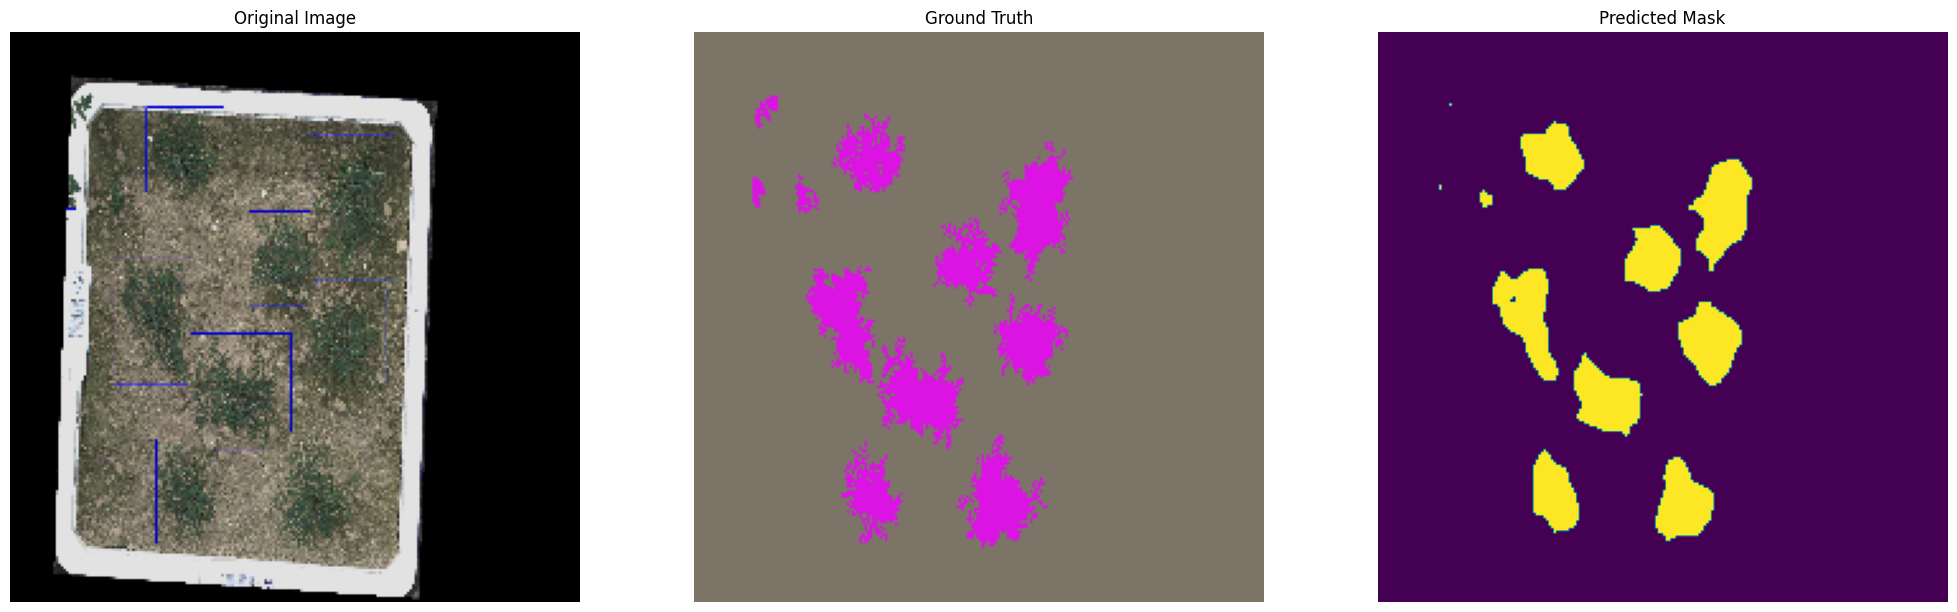

In [14]:
def tranformation(t): 
    invTrans = tfs.Compose([ tfs.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                tfs.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]) ])
    
    rgb = True if len(t) == 3 else False
    
    return (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8) if rgb else (t*255).detach().cpu().numpy().astype(np.uint8)

def plot(rows, cols, count, im, gt = None, title = "Original Image"):
    
    plt.subplot(rows, cols, count)
    plt.imshow(tn_2_np(im.squeeze(0).float())) if gt else plt.imshow(tranformation(im.squeeze(0)))
    plt.axis("off"); plt.title(title)
    
    return count + 1

def inference(dl, model, device, n_ims = 3):
    
    cols = n_ims // 3; rows = n_ims // cols
    
    count = 1
    ims, gts, preds = [], [], []
    for idx, data in enumerate(dl):
        im, gt = data
        with torch.no_grad(): pred = torch.argmax(model(im.to(device)), dim = 1)
        ims.append(im); gts.append(gt); preds.append(pred)
        
    plt.figure(figsize = (25, 20))
    for idx, (im, gt, pred) in enumerate(zip(ims, gts, preds)):
        if idx == cols: break
        count = plot(cols, rows, count, im)
        count = plot(cols, rows, count, im = gt, gt = True, title = "Ground Truth")
        count = plot(cols, rows, count, im = pred, title = "Predicted Mask")

inference(test_dl, model = model, device = device)